In [1]:
from inception_v4 import InceptionV4
from keras.applications.densenet import DenseNet201
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, Dropout, concatenate, Input, Activation, normalization, GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model, model_from_json, Input
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import SaveModelOnMAE_no, generate_generator, read_image_and_K_from_dir, read_48_points


%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
random.seed(7)
net = 'DenseNet201'
with_K = 'no'
idx_test = [17, 13, 20, 21]
save_dir_weights = './weights/weights_' + with_K + '_K/'


# Dataset
dir_path = './data/csv_files'
train_paths, train_labels, train_K, test_paths, test_labels, test_K = read_image_and_K_from_dir(dir_path, idx_test=idx_test)

test_paths_48, test_labels_48, test_K_48 = read_48_points(
    dir_path='./data/csv_files', dir_points='./data/48_points', idx_test=idx_test
)
test_paths_48, test_labels_48, test_K_48 = np.squeeze(test_paths_48).tolist(), np.squeeze(test_labels_48).tolist(), np.squeeze(test_K_48).tolist()

indexes_rand = list(range(len(train_K)))
random.shuffle(indexes_rand)
train_paths, train_labels, train_K = np.asarray(train_paths)[indexes_rand].tolist(), np.asarray(train_labels)[indexes_rand].tolist(), np.asarray(train_K)[indexes_rand].tolist()

idx_validate = np.loadtxt('./data/validation_selection_index.txt').astype(int)
validate_paths, validate_labels, validate_K = np.asarray(test_paths)[idx_validate].tolist(), np.asarray(test_labels)[idx_validate].tolist(), np.asarray(test_K)[idx_validate].tolist()

indexes_rand = list(range(len(test_K)))
random.shuffle(indexes_rand)
test_paths, test_labels, test_K = np.asarray(test_paths)[indexes_rand].tolist(), np.asarray(test_labels)[indexes_rand].tolist(), np.asarray(test_K)[indexes_rand].tolist()

print('\t\tpath\tlabel\tK')
print('train:\t\t{}\t{}\t{}'.format(len(train_paths), len(train_labels), len(train_K)))
print('val:\t\t{}\t{}\t{}'.format(len(validate_paths), len(validate_labels), len(validate_K)))
print('test:\t\t{}\t{}\t{}'.format(len(test_paths), len(test_labels), len(test_K)))
print('test_48:\t{}\t{}\t{}'.format(len(test_paths_48), len(test_labels_48), len(test_K_48)))

/home/chengxg/anaconda2/envs/zp_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Reading 	train and validation set 	from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
Reading 	test_48 set 			from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
		path	label	K
train:		1047750	1047750	1047750
val:		500	500	500
test:		347700	347700	347700
test_48:	195	195	195


In [2]:
def head_model(input_shape=(150, 150, 4)):
    input_tensor = Input(input_shape)
    # x = Conv2D(32, (5, 5), activation='relu', padding='valid')(input_shape)
    x = Conv2D(128, (1, 1), activation='relu', name='head_conv1')(input_tensor)
    x = Conv2D(3, (1, 1), activation='relu', name='head_conv2')(x)
    model = Model(inputs=input_tensor, outputs=x, name='head')
    return model


def tail_model(input_tensor):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(1, activation='relu')(x)
    model = Model(inputs=input_tensor, outputs=x, name='tail')
    return model


if with_K == 'head':
    head_model = head_model()
    body_model = Model(
        inputs=head_model.inputs,
        outputs=DenseNet201(weights='imagenet', include_top=False)(head_model.outputs)
    )
    x = body_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='relu')(x)

    model = Model(inputs=body_model.inputs, outputs=x, name=net)
    model.compile(loss='mean_absolute_error', optimizer='adam')
elif with_K == 'no':
    base_model = DenseNet201(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='relu')(x)
    model = Model(inputs=base_model.inputs, outputs=x, name=net)
    model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [ ]:
model = load_model('./acceptable_weights/weights_head_K/inceptionV4_head_K_MAE0.563.hdf5')

In [3]:
batch_size_train = 32
epochs_per_iteration = 32
batch_size_validate = len(validate_labels) // 5

if not os.path.exists(save_dir_weights):
    os.mkdir(save_dir_weights)

checkpointer_best = ModelCheckpoint(
    filepath=save_dir_weights + net + '.hdf5',
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
saver_MAE = SaveModelOnMAE_no()
print('Training ...')
train_generator = generate_generator(train_paths, train_labels, train_K, batch_size_train, net=net, with_K=with_K)
validate_generator = generate_generator(validate_paths, validate_labels, validate_K, batch_size_validate, net=net, with_K=with_K)
history = model.fit_generator(
    train_generator, steps_per_epoch = np.ceil(len(train_paths)/batch_size_train/epochs_per_iteration),
    epochs=epochs_per_iteration * 2,
    validation_data=validate_generator, validation_steps=1,
    verbose=1, callbacks=[checkpointer_best, saver_MAE]
)

Training ...
Epoch 1/64
1024/1024 [==============================] - 448s 438ms/step - loss: 1.9306 - val_loss: 85905.4844

Epoch 00001: val_loss improved from inf to 85905.48438, saving model to ./weights/weights_no_K/DenseNet201.hdf5
Epoch 2/64
1024/1024 [==============================] - 407s 397ms/step - loss: 0.7831 - val_loss: 0.7826

Epoch 00002: val_loss improved from 85905.48438 to 0.78260, saving model to ./weights/weights_no_K/DenseNet201.hdf5
Epoch 3/64
1024/1024 [==============================] - 401s 392ms/step - loss: 0.6658 - val_loss: 0.7009

Epoch 00003: val_loss improved from 0.78260 to 0.70093, saving model to ./weights/weights_no_K/DenseNet201.hdf5
Epoch 4/64
1024/1024 [==============================] - 393s 384ms/step - loss: 0.5560 - val_loss: 0.7470

Epoch 00004: val_loss did not improve from 0.70093
Epoch 5/64
1024/1024 [==============================] - 394s 385ms/step - loss: 0.4739 - val_loss: 0.6783

Epoch 00005: val_loss improved from 0.70093 to 0.67831, s


Epoch 00043: val_loss did not improve from 0.35090
Epoch 44/64
1024/1024 [==============================] - 391s 382ms/step - loss: 0.2166 - val_loss: 1.0060

Epoch 00044: val_loss did not improve from 0.35090
Epoch 45/64
1024/1024 [==============================] - 391s 382ms/step - loss: 0.2372 - val_loss: 0.7055

Epoch 00045: val_loss did not improve from 0.35090
Epoch 46/64
1024/1024 [==============================] - 391s 381ms/step - loss: 0.2264 - val_loss: 0.4671

Epoch 00046: val_loss did not improve from 0.35090
Saving to weights/weights_no_K/DenseNet201_no_K_MAE0.467.hdf5
Epoch 47/64
1024/1024 [==============================] - 390s 381ms/step - loss: 0.2640 - val_loss: 0.6064

Epoch 00047: val_loss did not improve from 0.35090
Saving to weights/weights_no_K/DenseNet201_no_K_MAE0.606.hdf5
Epoch 48/64
1024/1024 [==============================] - 391s 381ms/step - loss: 0.2178 - val_loss: 1.0404

Epoch 00048: val_loss did not improve from 0.35090
Epoch 49/64
1024/1024 [======

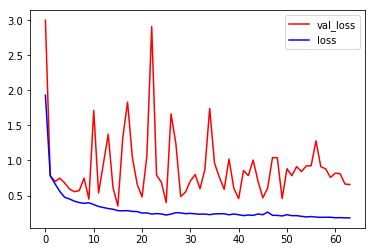

In [5]:
vl, l = history.history['val_loss'], history.history['loss']
vl = np.asarray(vl)
th = 3
vl[vl > th] = th
plt.plot(vl, 'r')
plt.plot(l, 'b')
plt.legend(['val_loss', 'loss'])
plt.show()

1/18 Loading ./weights/weights_no_K/DenseNet201_no_K_MAE0.351.hdf5 ...
(195,)


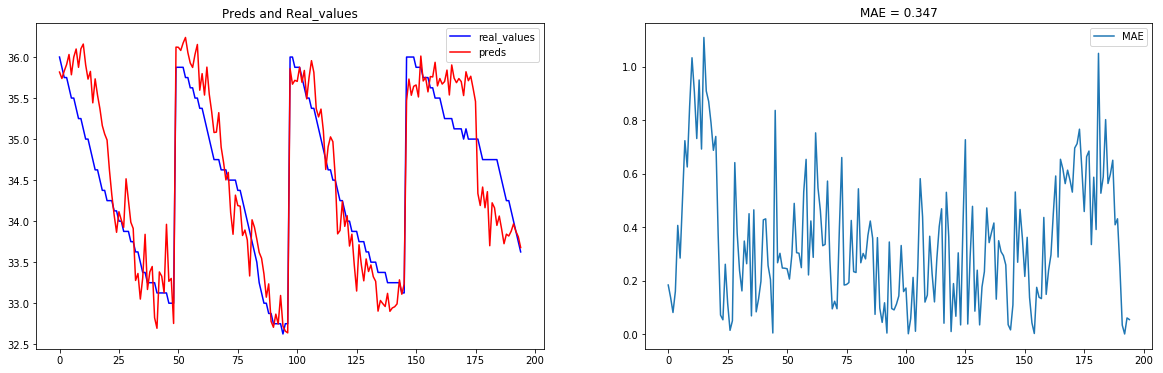

In [2]:
# test 0.351
model_paths = sorted([save_dir_weights+i for i in os.listdir(save_dir_weights) if 'MAE' in i], key=lambda x: float(x.split('MAE')[-1][:-len('.hdf5')]))
cursor = 0
for idx, m in enumerate(model_paths[cursor:cursor+1]):
    print('{}/{} Loading'.format(idx+1+cursor, len(model_paths)), m, '...')
    model = load_model(m)
    generator_for_test = generate_generator(test_paths_48, test_labels_48, test_K_48, len(test_K_48), net=net, with_K=with_K)
    X_test, Y_test = generator_for_test.__next__()
    preds = np.squeeze(model.predict(X_test))
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))
    ax0.plot(Y_test, 'b')
    ax0.plot(preds, 'r')
    ax0.legend(['real_values', 'preds'])
    ax0.set_title('Preds and Real_values')
    ax1.plot(np.abs(preds - Y_test))
    ax1.legend(['MAE'])
    MAE = round(np.mean(abs(preds - Y_test)), 3)
    ax1.set_title('MAE = {}'.format(MAE))
    print(np.unique(preds).shape)
    plt.show()

In [4]:
import pandas as pd
label_pred = np.hstack([np.asarray(range(Y_test.shape[0])).reshape(-1, 1), Y_test.reshape(-1, 1), preds.reshape(-1, 1)])
label_pred = pd.DataFrame(label_pred)
label_pred.to_csv(
    os.path.join('preds', 'preds_' + with_K + '_K', '_'.join([net, with_K, 'K_MAE', str(MAE) + '.txt'])),
    index=None,
    header=['index', 'label', 'prediction']
)